# Piezo Antenna

## Introduction

Pointing out:
 - antennae as a common concept for near-range orientation
 - mechanoreceptors, especially the johnston's organ
 - vibration sensitivity of antennae
 - prior approaches to construct a biomimetic antenna
     - results of these approaches
     - drawbacks of these approaches
 - what is different in this approach




Most insects utilize a pair of antennae to sense their near-range environment. When blindfolded these insects are still capable of climbing obstacles and finding footholds for their front legs using their antennae [[Dürr01]](https://www.ncbi.nlm.nih.gov/pubmed/22098903). Different types of mechanoreceptors present in each antenna, are involved to perform this kind of orientation. One of these receptors - the Johnston's organ - is correlated to the sensing of antennal vibrations [[JC96]](https://link.springer.com/article/10.1007/BF02346378).
As vibrations are characterized by their amplitude, frequency and phase, all further information about the origin of the vibration is encoded in these properties. This includes forces applied to the antenna on movement or on a contact with another object.
Prior approaches to construct a biomimetic antenna have proven, that vibration properties can be exploited to estimate a position of a contact on the antenna or material properties and texture of any touched object [[KM04]](http://www.ti.uni-bielefeld.de/downloads/publications/whisker3.pdf). .....

>Therefore an artificial antenna needs to be constructed that is capable of providing distance information of objects with sufficient precision and a small latency. For footstep planning, the robot needs to get an immediate feedback of it’s surroundings, especially when the knowledge is restricted to the range of the robot. In the hereinafter described experiment, the properties and performance of an antenna that utilizes a piezoelectric sensor gets explored. More precisely it is examined, whether the signal from this antenna contains the required distance estimation on objects it touches.

## Materials and Methods
### Experimental setup
### Data acquisition
### Analytical methods

First, the recorded data must be read and processed for the analysis.

(5.95, 6.1)

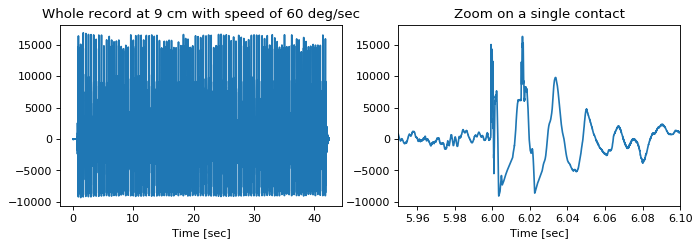

In [178]:
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import os
import re


FRAMERATE = 0    # init framerate (gets assigned when wav files are read)

# load and prepare the data
data_dir = 'data'
files = os.listdir(data_dir)
rawdata = pd.DataFrame(columns=['record', 'distance', 'speed'])

def samples_to_time(num_samples):
    '''
    Get a number of samples and outputs the correlating length in time.
    '''
    return np.array(range(num_samples)) / 44100.

# search folder for wav files
id = 0
for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    FRAMERATE = fs
    # parse integers from filename (distance, speed, material)
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    # put the data into the DataFrame
    rawdata = rawdata.append(dict(
        { 'record'   : data, 
          'distance' : decoded_classes[0],
          'speed'    : decoded_classes[1] }), ignore_index=True)
    id += 1

N_CLASSES = len(rawdata)
rawdata = rawdata.sort_values(by=['distance','speed'])
rawdata['id'] = range(len(rawdata))
rawdata = rawdata.set_index('id', drop=True)
plt.figure(num=None, figsize=(10, 3), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(samples_to_time(len(rawdata['record'][13])),rawdata['record'][13])
plt.xlabel("Time [sec]")
plt.title("Whole record at 9 cm with speed of 60 deg/sec")
plt.subplot(1, 2, 2)
plt.xlabel("Time [sec]")
plt.title("Zoom on a single contact")
plt.plot(samples_to_time(len(rawdata['record'][13])),rawdata['record'][13])
plt.xlim((5.95, 6.1))

### Extracting the peaks

The records were stored by distance and motor speed. Each file contains 100 recorded contact events and these have to be cut out and stored separately for further processing. Each contact event necessarily exceeds the given threshold, because this principle got also used to detect the contacts in the experimental setup. Due to rebounces and induced vibration, this threshold is exceeded several times during acontact event. Extracting regions of peaks can happen on different ways:
 - The start of a contact is the first transgression of the threshold
 - The start of a contact is the last transgression of the threshold
 - The start of a contact is the max value reached during a contact event.
 
The following implementation allows finding peaks using the first two methods.

In [179]:
EXPECTED_CONTACTS = 100
THRESHOLD = 5000
FRAGMENT_SIZE = 2048
SAMPLES_BETWEEN_CONTACTS = 4410

data = rawdata
    

def find_peaks(x, method='last_peaks'):
    above_th = pd.Series(x) > THRESHOLD
    # find every threshold transgression
    above_th = pd.Series(above_th.index[above_th == True].tolist()).astype(int)
    diff = above_th.diff(periods=-1).abs()
    
    if method == 'first_peaks':
        diff = diff.shift(1).fillna(SAMPLES_BETWEEN_CONTACTS)
    
    peaks_indices = diff.index[diff >= SAMPLES_BETWEEN_CONTACTS].tolist()
    peaks_indices.append(len(above_th) - 1)
    peaks = above_th[peaks_indices].reset_index(drop=True)
    
    return peaks

def extract_peaks(d, peaks):
    idx_peaks = pd.Index(peaks)
    contacts = []
    for c_idx in peaks:
        contacts.append(d[c_idx:c_idx + FRAGMENT_SIZE].tolist())
    return contacts

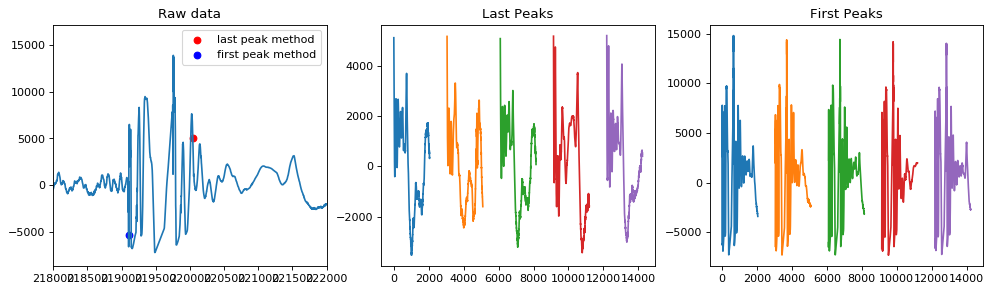

In [187]:
for i in range(N_CLASSES):
    d = pd.Series(data['record'][i])
    peaks_fst = find_peaks(d.abs(), method='first_peaks')
    data.at[i, 'contacts_fst'] = 0
    data['contacts_fst'] = data['contacts_fst'].astype(object)
    data.at[i, 'contacts_fst'] = np.array(extract_peaks(d, peaks_fst))
    
    peaks_lst = find_peaks(d.abs(), method='last_peaks')
    data.at[i, 'contacts_lst'] = 0
    data['contacts_lst'] = data['contacts_lst'].astype(object)
    data.at[i, 'contacts_lst'] = np.array(extract_peaks(d, peaks_lst))  
    
    
plt.figure(num=None, figsize=(15, 4), dpi=80)
plt.subplot('131')
last_series = data['record'][len(data['record'])-1]
plt.title("Raw data")
plt.plot(last_series)
plt.scatter(peaks_lst, [ last_series[i] for i in peaks_lst ], color='r', label='last peak method')
plt.scatter(peaks_fst, [ last_series[i] for i in peaks_fst ], color='b', label='first peak method')
plt.legend()
plt.xlim((218000, 222000))
for i in range(5):
    xs = range(FRAGMENT_SIZE*(i)+1000*i,FRAGMENT_SIZE*(i+1)+1000*i)
    plt.subplot('132')
    plt.plot(xs, data.loc[len(data['record'])-1, 'contacts_lst'][i])
    plt.title("Last Peaks")
    plt.subplot('133')
    plt.plot(xs, data.loc[len(data['record'])-1, 'contacts_fst'][i])
    plt.title("First Peaks")

### Spectrogram

The spectrogram shows the time course of frequency power.

Text(0,0.5,'Frequency [log(Hz)]')

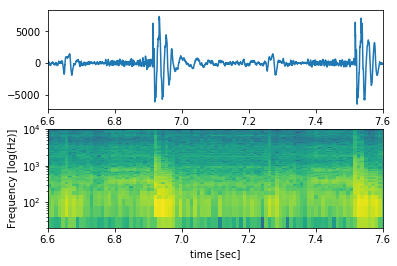

In [188]:
import scipy.signal as signal

SEGMENT_LEN = 535
dat = data['record'][0]

def generate_spectrogram(data):
    '''
    Generates a spectrogram with logarithmically scaled frequency dimension.
    '''
    f, t, Sxx = signal.spectrogram(data,
                                 fs=FRAMERATE,
                                 scaling='density',
                                 mode='psd',
                                 nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx
    

f, t, Sxx = generate_spectrogram(dat)

fig, ax = plt.subplots(2,1)
ax[1].set_ylim((20, 10000))
# show two seconds of the signals spectrogram
ax[0].set_xlim((6.6, 7.6))
ax[1].set_xlim((6.6, 7.6))
# plot raw signal
ax[0].plot(samples_to_time(len(data['record'][0])), dat)
# plot spectrogram
ax[1].pcolormesh(t, f, Sxx, label='spectrogram i')
ax[1].set_yscale('log')
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("Frequency [log(Hz)]")

# Frequency spectra

The frequency spectra show which frequencies are active in a given interval of the records. It is expected, that contacts further away from the motor produce relatively high frequencies compared contacts closer to the motor.
The spectra below were generated using the welch method. It cuts its input into chunks and then returns the mean spectrum of those chunks.
The following plots allow the comparism of different spectra:
 - mean spectra that belong to the same speed, but different distances
 - mean spectra of the different used speeds within each distance

In [189]:
# data[data.distance == 11]['contacts_lst']

Text(0,0.5,'Frequency power')

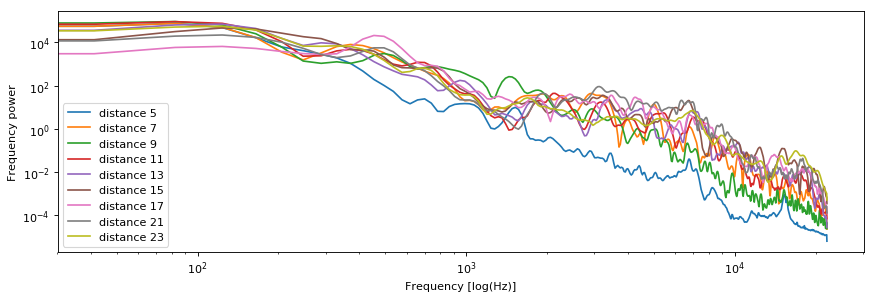

In [190]:
plt.figure(num=None, figsize=(13, 4), dpi=80)

def generate_spectrum(data):
    return signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)

# generate mean power spectra over every hit for each distance
# mean_spectra = pd.DataFrame()
total_powers = pd.DataFrame(columns=data['distance'].unique())
total_powers['speed'] = data['speed'].unique()
total_powers = total_powers.set_index('speed', drop=True)
for i in range(N_CLASSES):
    # get the time course of every contact related to one distance
    contacts = data['contacts_fst'][i]
    f, Pxx = generate_spectrum(contacts)
    # calculate the mean spectrum for one distance
    avg = np.mean(Pxx, axis=0)
    speed = data.loc[i, 'speed']
    distance = data.loc[i, 'distance']
    # store the total power to a dataframe
    total_powers.loc[speed, distance] = avg.sum()
    std_dev = np.std(Pxx, axis=0)
    Pxx = 10 * np.log10(Pxx)
    if speed == 100:
        plt.plot(f, avg, label='distance %d' % distance)
    
    # mean_spectra[i] = avg
    
# plot last spectrum
#f, ax = plt.subplots()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")
# plt.plot(f, avg) #, std_dev)

It would be desirable that the frequencies wouldn't change much with just the changing motor speed, but exclusively with distance. The following plot shows mean spectra across all speeds for each distance. The standard deviation is partially really high, but that is due to the power that changes according to the speed. When using relative powers by deviding each spectrum by its total power, the standard deviation looks better. Still in the high freuency bands, there is a high deviation.

Text(0,0.5,'Frequency power')

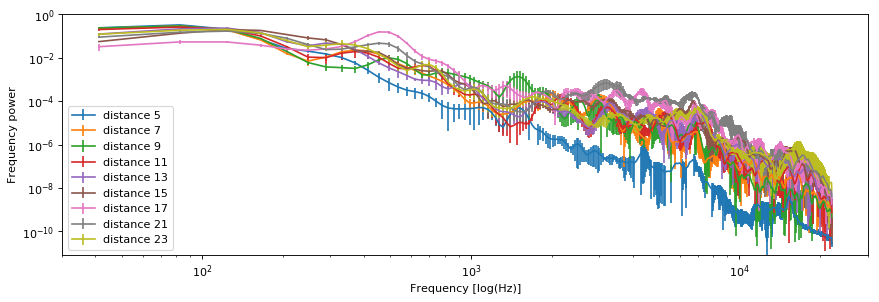

In [191]:
# generate spectra equal speed, varying distance
# generate spectra for different distances, taking the mean over the different speeds

plt.figure(num=None, figsize=(13, 4), dpi=80)
plt.xscale('log', nonposx='mask')
plt.yscale('log', nonposy='mask')

for dist in data.distance.sort_values().unique():
    df = data[data.distance == dist]
    averages = []
    for contacts in df['contacts_fst']:
        f, Pxx = generate_spectrum(contacts)
        avg = np.mean(Pxx, axis=0)
        power = avg.sum()
        averages.append(avg / power)
    average = np.mean(averages, axis=0)
    std_dev = np.std(averages, axis=0)
    plt.errorbar(f, average, std_dev, label='distance %d' % dist)
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

## Eliminating the frequency power

The force of the contact and thus the power of the frequencies, depend on the motor velocity. To narrow the focus of the analysis on the frequencies, different approaches would be possible.

### Relative power
A solution could be to generate spectra of all contact records just like above, then calculate the overall power of each one by integration and devide the whole spectrum by that value. The problem with this approach is the noise which originally stays on a pretty constant level and by deviding it with the overall spectra power, it would change to different levels.

### Power relative to the angular motor velocity
Putting the overall spectral power in relation to the angular velocity of the motor for every distance, might solve this problem. The idea is to vary the motor velocity for every distance, such that each distance will produce an equally powerful spectrum. The plot below, correlates the total power of a contact-spectrum against the motor speed. Per distance, we get 5 different mean power spectra, that got produced using 5 different motor velocities.

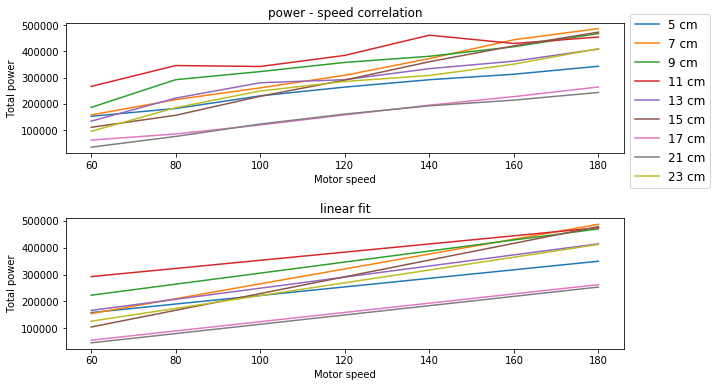

In [192]:
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties

# set plot to a bigger size
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].set_title("power - speed correlation")
ax[1].set_title("linear fit")

def lin_reg(xs, ys):
    '''
    Returns a linear regression between lowest and highest motor speed of
    the input arrays for first and second dimension.
    '''
    slope, intercept, r, p, sdterr = linregress(ms, tp)
    min_speed = data['speed'].min()
    max_speed = data['speed'].max()
    xs = np.array([min_speed, max_speed])
    return xs, slope * xs + intercept

# for every distance do an own plot
for distance in data['distance'].sort_values().unique():
    
    ms = total_powers[distance].index.tolist()        # every motor speed
    tp = total_powers[distance].tolist()              # total powers of the mean spectra for every speed
    ms, tp = zip(*sorted(zip(ms, tp)))                # sort both lists according to the motor speeds
    xs, ys = lin_reg(ms, tp)                          # fit a linear kurve
    
    ax[0].plot(ms, tp, label='%d cm' % distance)
    ax[1].plot(xs, ys, label='%d cm' % distance)

fontP = FontProperties()
fontP.set_size('large')
ax[0].set_xlabel("Motor speed")
ax[0].set_ylabel("Total power")
ax[1].set_xlabel("Motor speed")
ax[1].set_ylabel("Total power")
plt.subplots_adjust(hspace=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 1.9), prop=fontP)

The result is not as expected. The presumption was, that the powers would increase with a higher velocity, but for some distances (11 cm, 9 cm, 7 cm, 5 cm) it is the opposite. It is only the case for consecutive values below a distance of 13. This might correlate with the sensor position. The tip of the sensor is locate around 11 to 13 cm on the antenna. It is still counterintuitive behaviour.